In [23]:
import random
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd
import math

In [24]:
def haversine(pair1, pair2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [pair1[1], pair1[0], pair2[1], pair2[0]])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000

In [25]:
df = pd.read_csv('output.csv')
df.head()

,lat1,lng1,lat2,lng2,jam_factor,ratio_of_speed_to_free_flow
0,12.91561,77.56526,12.91572,77.56522,1.2,0.918919
1,12.91572,77.56522,12.91577,77.56520,1.2,0.918919
2,12.91577,77.56520,12.91608,77.56508,1.2,0.918919
3,12.91608,77.56508,12.91632,77.56499,1.2,0.918919
4,12.91632,77.56499,12.91646,77.56493,1.2,0.918919


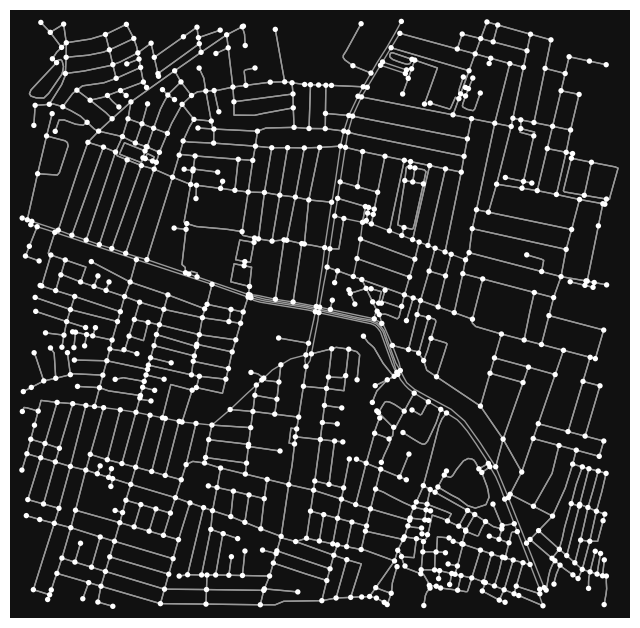

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [26]:
Gp = ox.graph_from_point((12.921789, 77.560214), dist=700)
ox.plot_graph(Gp)

In [5]:
def dfs_paths(graph, start, end):
    visited = set()
    paths = []

    def dfs(curr, path):
        visited.add(curr)
        path.append(curr)

        if curr == end:
            paths.append(list(path))
        else:
            for neighbor in graph[curr]:
                if neighbor not in visited:
                    dfs(neighbor, path)

        visited.remove(curr)
        path.pop()

    dfs(start, [])
    return paths

In [27]:
c = len(Gp.nodes)
for u, v in Gp.edges.items():
    if 'geometry' in v.keys():
        # print(v['geometry'].wkt[12:-1].split(','))
        c += len(v['geometry'].wkt[12:-1].split(','))
        # c += 1
print(c)

2733


In [28]:
G = nx.MultiDiGraph()
temp_dict = dict()
node_index = 0
node_ids = []

for u,v in Gp.edges.items():
    if u[0] not in temp_dict.keys():
        nodeId = node_index; G.add_node(nodeId); temp_dict[u[0]] = nodeId; node_index += 1; node_ids.append(nodeId)
    else:
        nodeId = temp_dict[u[0]]
    
    if u[1] not in temp_dict.keys():
        nodeId2 = node_index; G.add_node(nodeId2); temp_dict[u[1]] = nodeId2; node_index += 1; node_ids.append(nodeId2)
    else:
        nodeId2 = temp_dict[u[1]]

    G.nodes[nodeId]['lng'] = Gp.nodes[u[0]]['x']
    G.nodes[nodeId]['lat'] = Gp.nodes[u[0]]['y']
    G.nodes[nodeId2]['lng'] = Gp.nodes[u[1]]['x']
    G.nodes[nodeId2]['lat'] = Gp.nodes[u[1]]['y']

    if 'geometry' in v.keys():
        prev_node = nodeId
        for i in v['geometry'].wkt[12:-1].split(','):
            temp_ = i.split()
            
            nodeId3 = node_index; node_index += 1; node_ids.append(nodeId3)
            G.add_node(nodeId3)
            
            G.nodes[nodeId3]['lng'] = float(temp_[0])
            G.nodes[nodeId3]['lat'] = float(temp_[1])
            
            G.add_edge(prev_node, nodeId3, dist=haversine((G.nodes[prev_node]['lat'], G.nodes[prev_node]['lng']), (G.nodes[nodeId3]['lat'], G.nodes[nodeId3]['lng'])), oneway=v['oneway'])
            prev_node = nodeId3
        G.add_edge(prev_node, nodeId2, dist=0.0, oneway=v['oneway'])
    else:
        G.add_edge(nodeId, nodeId2, dist=v['length'], oneway=v['oneway'])

# relabel node indices from 0 to n
mapping = {node_ids[i]: i for i in range(len(node_ids))}
G = nx.relabel_nodes(G, mapping)

print(c == len(G.nodes))

True


In [29]:
matched_edges = list()
edge_data = G.edges(data=True)
unmatched_rows = []

edge_jam = []
edge_ratio_of_speed_to_free_flow = []

for row in df.itertuples():
    lat1, lng1, lat2, lng2 = row.lat1, row.lng1, row.lat2, row.lng2
    
    for u, v, data in edge_data:
        if (u in matched_edges) or (v in matched_edges):
            continue
            
        if (abs(G.nodes[u]['lng'] - lng1) < 0.0002 and abs(G.nodes[u]['lat'] - lat1) < 0.0002 and
            abs(G.nodes[v]['lng'] - lng2) < 0.0002 and abs(G.nodes[v]['lat'] - lat2) < 0.0002):
            print(G.nodes[v]['lat'], G.nodes[v]['lng'], 'marker', sep=',')
            print(lat2, lng2, 'marker', sep=',')
            print('------------------')
            edge_jam.append(data['dist'] * row.jam_factor)
            edge_ratio_of_speed_to_free_flow.append(row.ratio_of_speed_to_free_flow)
            
            matched_edges.append((u, v))
            
            break
            
    else:
        # If no matching edge was found, add the row to a separate list
        unmatched_rows.append(row)
            

print(len(matched_edges), len(edge_jam), len(edge_ratio_of_speed_to_free_flow))
tdf = pd.DataFrame({'edge': matched_edges, 
                    'jam_factor': edge_jam, 
                    'ratio_of_speed_to_free_flow': edge_ratio_of_speed_to_free_flow})


12.9158681,77.5651834,marker
12.91572,77.56522,marker
------------------
12.9158498,77.5653266,marker
12.9157701,77.5652001,marker
------------------
12.916439,77.5648146,marker
12.9164601,77.5649301,marker
------------------
12.9172781,77.5646218,marker
12.9173201,77.5646001,marker
------------------
12.9178079,77.5644108,marker
12.9176401,77.5644801,marker
------------------
12.9178408,77.5644935,marker
12.9177701,77.56443,marker
------------------
12.9178079,77.5644108,marker
12.91793,77.56436,marker
------------------
12.9181025,77.5642964,marker
12.91808,77.56429,marker
------------------
12.9181917,77.5643441,marker
12.91828,77.56419,marker
------------------
12.9182916,77.5642124,marker
12.9184301,77.5641101,marker
------------------
12.9185031,77.5642116,marker
12.91857,77.56403,marker
------------------
12.9185742,77.5640499,marker
12.9187001,77.5639501,marker
------------------
12.9186863,77.5639854,marker
12.91888,77.56383,marker
------------------
12.9189909,77.5637823,mark

In [30]:
tdf = tdf.drop_duplicates()
len(tdf)

119

In [31]:
tdf.head()

,edge,jam_factor,ratio_of_speed_to_free_flow
0,"(1270, 904)",12.9936,0.918919
1,"(902, 903)",9.2148,0.918919
2,"(905, 1093)",20.9124,0.918919
3,"(1092, 1702)",24.2016,0.918919
4,"(1702, 169)",75.8328,0.918919


In [32]:
len(G.edges)

4089

In [33]:
start_point = random.choice(tuple(G.nodes))
end_point = random.choice(tuple(G.nodes))

print(start_point,end_point)
print(G.nodes[start_point]["lat"], G.nodes[start_point]["lng"], "marker", sep=",")
print(G.nodes[end_point]["lat"], G.nodes[end_point]["lng"], "marker", sep=",")

1986 1145
12.9162269,77.563152,marker
12.9180977,77.5626146,marker


In [13]:
all_paths = dfs_paths(G, start_point, end_point)
print(all_paths)

KeyboardInterrupt: 

In [ ]:
for i in all_paths[0]:
    print(G.nodes[i]["y"], G.nodes[i]["x"], "marker", sep=",")

In [1]:
# Define a function to take an action in the environment
def take_action(env, state, action): # 1   3
    row, col = np.unravel_index(state, env.shape)
    if action == 0:  # move up
        row = max(row - 1, 0)
    elif action == 1:  # move down
        row = min(row + 1, env.shape[0] - 1)
    elif action == 2:  # move left
        col = max(col - 1, 0)
    elif action == 3:  # move right
        col = min(col + 1, env.shape[1] - 1)
    next_state = np.ravel_multi_index((row, col), env.shape)
    reward = env[row][col]
    done = (reward == 1)
    return next_state, reward, done

In [6]:

# Define the grid world environment
env = np.array([
    [0, 0, 0, 0],
    [0, -1, 0, -1],
    [0, 0, 0, -1],
    [-1, 0, 0, 1]
])

# Define the Q-table and hyperparameters
num_states = env.size
num_actions = 4
Q = np.zeros((num_states, num_actions))
gamma = 0.9  # discount factor
alpha = 0.1  # learning rate
epsilon = 0.2

# Define the training loop
num_episodes = 1000
for i in range(num_episodes):
    state = np.random.randint(num_states)  # initialize the starting state
    done = False
    while not done:
        if random.random() < epsilon :
            action = random.randint(0,num_actions-1)
        else:
            action = np.argmax(Q[state])  # choose the action with highest Q-value
        next_state, reward, done = take_action(env, state, action)  # take the action and observe the next state and reward
        max_q_next = np.max(Q[next_state])  # calculate the maximum Q-value for the next state
        Q[state][action] += alpha * (reward + gamma * max_q_next - Q[state][action])  # update the Q-value for the current state and action
        state = next_state  # update the current state
    
    print(i,reward)



# Print the final Q-table
print("Final Q-table:")
print(Q)


0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 1
128 1
129 1
130 1
131 1
132 1
133 1
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 1
151 1
152 1
153 1
154 1
155 1
156 1
157 1
158 1
159 1
160 1
161 1
162 1
163 1
164 1
165 1
166 1
167 1
168 1
169 1
170 1
171 1
172 1
173 1
174 1
175 1
176 1
177 1
178 1
179 1
180 1
181 1
182 1
183 1
184 1


In [21]:
state = np.random.randint(num_states)  # initialize the starting state
print(state)
done = False
while not done:
    action = np.argmax(Q[state])  # choose the action with highest Q-value
    next_state, reward, done = take_action(env, state, action)  # take the action and observe the next state and reward
    print(action,next_state,reward)
    # max_q_next = np.max(Q[next_state])  # calculate the maximum Q-value for the next state
    # Q[state][action] += alpha * (reward + gamma * max_q_next - Q[state][action])  # update the Q-value for the current state and action
    state = next_state  # update the current state
print(Q)



4
0 0 0
3 1 0
3 2 0
1 6 0
1 10 0
1 14 0
3 15 1
[[ 1.14282005  1.26021663  1.30702352  2.64408503]
 [ 1.85496085  0.67188496  1.22052737  3.03068565]
 [ 2.45389708  3.43952365  1.9955399   1.98811166]
 [ 0.96828284  0.03862367  2.98203125  0.69503988]
 [ 2.31016984  0.97273948  1.17151795  0.48117272]
 [ 0.91040341  3.16107407  0.61912198  1.0150608 ]
 [ 2.42339174  3.8616043   1.18773077  0.19629508]
 [ 2.47649325  0.94105022  0.78432933 -0.84027414]
 [ 1.97552573 -0.26546342  0.69481013  1.4232336 ]
 [ 0.36568587  3.71164221  0.79664412  1.82556909]
 [ 2.66832539  4.32635976  2.48574246  2.11915016]
 [ 0.04627127  4.56277867  0.9108632   0.81546815]
 [ 1.62547765  0.09147622  0.06006029  0.36830477]
 [ 1.75917941  1.83379105 -0.39575013  4.28071919]
 [ 3.3975011   3.87852114  3.38205077  4.84321573]
 [ 0.54259043  4.30398798  1.57488708  0.48218073]]


In [41]:
c =0
for i in G.nodes:
    # print(tuple(G.neighbors(i)))
    c = max(len(tuple(G.neighbors(i))), c)
c

4